In [1]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import camb 
from camb import model, initialpower
%matplotlib inline


In [2]:
#Generate a basic map
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    _NPIX = 12*_NSIDE**2
    return   np.linspace(_strt,_stop,_NPIX)        #set an array to generate a map


In [3]:
#Downloads the higher resolution WMAP data 
!healpy_get_wmap_maps.sh
wmap_map_I = hp.read_map("wmap_band_iqumap_r9_7yr_W_v4.fits")
hp.write_map("my_map.fits", wmap_map_I, overwrite=True)


URL transformed to HTTPS due to an HSTS policy
--2020-10-28 18:54:54--  https://lambda.gsfc.nasa.gov/data/map/dr4/skymaps/7yr/raw/wmap_band_iqumap_r9_7yr_W_v4.fits
Resolving lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)... 129.164.179.68, 2001:4d0:2310:150::68
Connecting to lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)|129.164.179.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

URL transformed to HTTPS due to an HSTS policy
--2020-10-28 18:54:55--  https://lambda.gsfc.nasa.gov/data/map/dr4/skymaps/7yr/raw/wmap_band_iqumap_r9_7yr_V_v4.fits
Resolving lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)... 129.164.179.68, 2001:4d0:2310:150::68
Connecting to lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)|129.164.179.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

URL transformed to HTTPS due t

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(sch

In [2]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    pars = camb.CAMBparams()
    pars.set_cosmology(H0 = parameters[0], ombh2 = parameters[1], omch2 = parameters[2], mnu = parameters[3],
                   omk = parameters[4], tau = parameters[5])
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
    pars.set_for_lmax(_lmax, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    totCL=powers['total']
    unlensedCL=powers['unlensed_scalar']
    _DL = totCL[:,0]  #gives the lensed scalar cls
    
    _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
    _CL = []
    for i in range(_lmax): #also limits the length of power spectrum to the requested length
        if i == 0:
            _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
        else:
            _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
    _CL = np.array(_CL)    
    
    return _CL


In [3]:
#PLots a map in the aithoff projection 
def aithoffmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [6]:
#Gives the resolution for an NSIDE and the number of pixels.
def basicmapdet(_NSIDE, _NPIX):     
    print("Approximate resolution at NSIDE {} is {:.2} deg".format(_NSIDE, hp.nside2resol(_NSIDE, arcmin=True) / 60))
    print('Number of pixels =',_NPIX)
    

In [4]:
#Generate a map given a power spectrum
def genmap(_cls, _NSIDE):   
    return hp.synfast(_cls, _NSIDE, new=True)   #pixwin=False, fwhm=np.radians(7.0),


In [5]:
#Generate a power spectrum given cls
def gencls(_map):
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)), new = True)    #lmax = 3NSIDE -1 by default


In [6]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.figure()
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")
    plt.show()


In [7]:
#Adds random noise to each pixel on a map given a variance 
def noisemap(_map,_var):
    _newmap = []
    _noisevec = []
    for i in range(len(_map)):
        _noisevec.append(np.random.normal(0,_var))
        _newmap.append(_map[i] + _noisevec[-1])
    _newmap = np.array(_newmap)    
    _noisevec = np.array(_noisevec)
    return [_newmap, _noisevec]


In [8]:
#Generate alms given cls
def genalms1(_cls, _NSIDE): #does this manually
    _alms = []
    _lmax = (3*_NSIDE) - 1
    for l in range(_lmax):
        _alms.append([]) 
        for m in range(_lmax): #set negative m's
            _alms[-1].append([np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])])
        _alms[-1].append([np.random.normal(0,_cls[l]),0.0])        #set m=0
        for m in range(_lmax):                    #set positive m's = -m's
            _alms[-1].append([_alms[l][(_lmax-m-1)][0]])
            _alms[-1][-1].append(-1.0*_alms[l][_lmax-m-1][-1])   #set imag part of positive m's = c.c. of negative m's.
    return _alms   


def genalms2(_cls, _NSIDE): #does this automatically
    return hp.synalm(_cls, lmax = ((3*_NSIDE)-1), new = True)

def maptoalms(_map, _lmax):
    return hp.map2alm(_map, _lmax)


In [9]:
def CLest(_alms, _lmax):
    return hp.alm2cl(_alms, lmax = _lmax)

In [10]:
def mapsmooth(_map, _lmax):
    return hp.smoothing(_map, lmax = _lmax)
    

In [ ]:
#negative log of the posterior, psi, ignoring the prior term.
#psi = 0.5*(d-Ya)^T(n^-1)*(d-Ya)

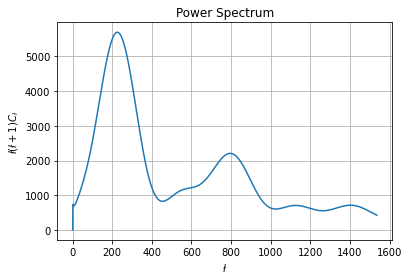

In [11]:
parameters = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066]
lmax = 1536  
cls1 = call_CAMB_map(parameters, lmax)
plotpwrspctrm(cls1)


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

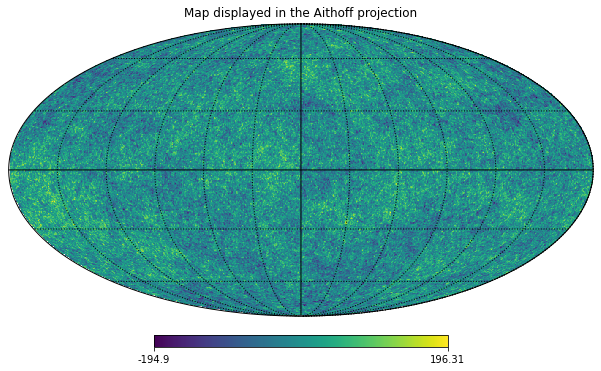

In [12]:
NSIDE = 512  #len(cls1)/3   #3*nside = len(cls)
map1 = genmap(cls1, NSIDE)  
map1 = mapsmooth(map1, lmax)
aithoffmap(map1)


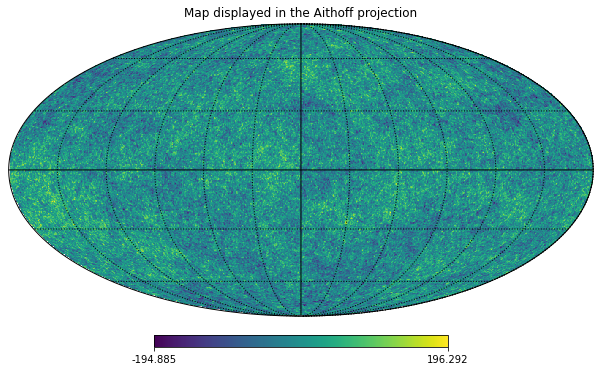

In [13]:
noisemap1 = noisemap(map1,0.05)
aithoffmap(noisemap1[0])


In [16]:
alms1 = maptoalms(noisemap1[0],lmax)


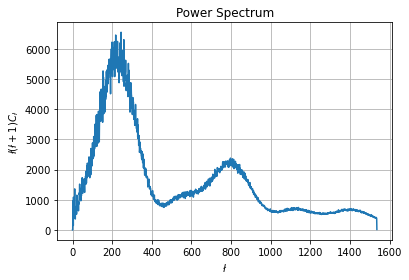

In [18]:
CLestimate = CLest(alms1, lmax)
plotpwrspctrm(CLestimate)
